In [1]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [2]:
#load data
DroneData = pd.read_csv('./IMU_camera Drone Synchronized training dataset_normal behabiour_no abnormalities/_slash_mavros_slash_imu_slash_data.csv')

In [3]:
def extract_normalized_imu_data(DroneData):
    """
    Extracts only the normal distribution z scores 
    of imu sensors from the data
    """
    imuParamsData = DroneData.loc[:,['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']]
    normImuData = (imuParamsData - imuParamsData.mean())/imuParamsData.std()
    return normImuData

def find_theta_score(Data):
    """
    Converts n dimensions to a single 1D score,
    for easier visualization
    """
    pca = PCA(n_components=1)
    pca.fit(Data)
    theta_score = pca.transform(Data)
    return theta_score

def plot_anomalies_in_1D(z_score, anomalyPrediction):
    """
    plots anomalies (red) and 1D z score of the dataset
    """
    plt.figure(figsize=(20,10))
    for i in range(len(z_score)):
        if anomalyPrediction[i] == True:
            plt.scatter(i,z_score[i],c = 'r')
    plt.plot(z_score)
    

In [4]:
#preprocess

normImuData = extract_normalized_imu_data(DroneData)
z_score = find_theta_score(normImuData)

In [5]:
#using IsoFo

#add your algos in this very format pls

from sklearn.ensemble import IsolationForest

#fit isofo model
clf = IsolationForest(n_estimators=10,contamination=float(.01))
clf.fit(normImuData)

#predict anomalies
tempanomalyPrediction = clf.predict(normImuData)
anomalyPrediction = tempanomalyPrediction == -1

/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/pratik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


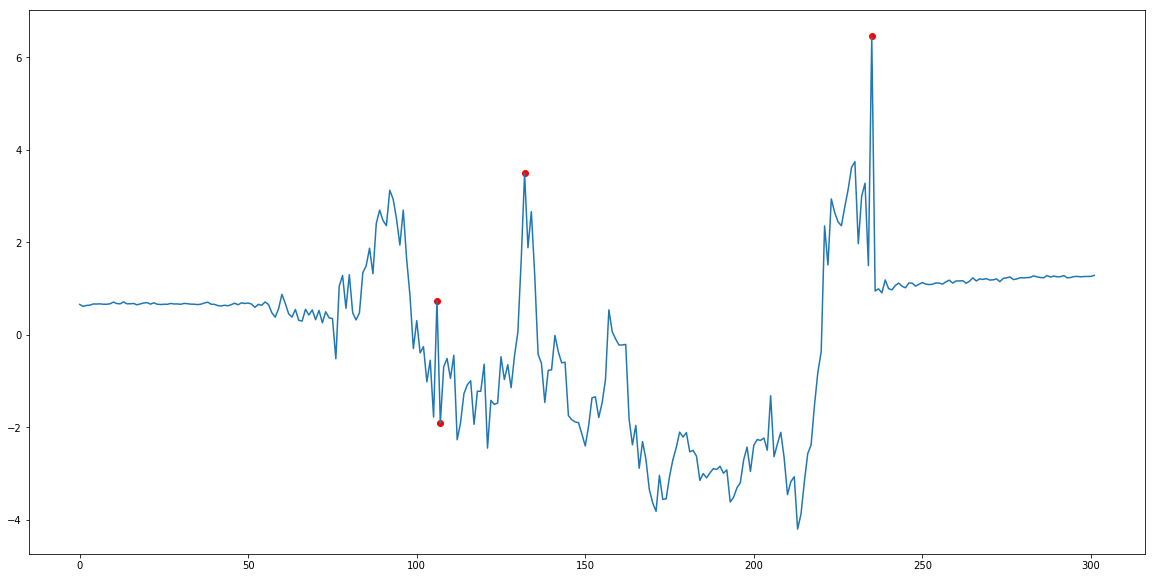

In [6]:
#isofo is statistical, so we need to specify contamination beforehand, 
#which may not be a good method since our problem is very sparse in nature

plot_anomalies_in_1D(z_score, anomalyPrediction)